# Detecting loadwords with Keras

### In this notebook you will:
1. Train a neural network using Keras.
1. Optimize hyperparameters for the Neural Net.
1. Record model training statistics for viewing with tensor board.
1. Save the best model using checkpoints. 
1. Compare the performance between the Neural Net and the Decision Tree classifier.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [53]:
import logging
import random
import pickle

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import density
from cltk.stem.latin.j_v import JVReplacer
from cltk.prosody.latin.scansion_constants import ScansionConstants
from cltk.prosody.latin.string_utils import remove_punctuation_dict
from cltk.tokenize.word import WordTokenizer
from cltk.corpus.readers import get_corpus_reader
from cltk.utils.featurization import word_to_features
from cltk.utils.file_operations import md5

plt.style.use('fivethirtyeight')
import logging
logging.disable(logging.WARNING)
K.tensorflow_backend._get_available_gpus()
logging.disable(logging.NOTSET)
K.tensorflow_backend._get_available_gpus()

[]

## Fix random seed values for reproducibility and tuning
see: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [4]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(12)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12) 

### Add parent directory to path so we can access our common code

In [5]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [6]:
from mlyoucanuse.featurize_text_fun import word_to_features

### Turn on logging, primarily so that library methods may report warnings, if any

In [7]:
LOG = logging.getLogger('make_model')
LOG.addHandler(logging.NullHandler())
logging.basicConfig(level=logging.INFO)
# tf.logging.set_verbosity(tf.logging.ERROR) # silence a deprecation warning; todo revisit

## Load the saved X,y matrix 
as created in the `detect_loanwords_problems_solutions` notebook

In [8]:
all_X = None
with open('all_X.pkl', 'rb') as pickle_file:
    all_X = pickle.load(pickle_file)
all_y = None
with open('all_y', 'rb') as pickle_file:
    all_y = pickle.load(pickle_file)
all_X.astype(np.float32)
all_y.astype(np.float32)

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

## Process the saved matrix

In [9]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)
# Partition equal sizes of test and validation sets
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [10]:
scaler = StandardScaler()
# try:  all_X.astype(np.float64)
# Fit scaler only on training slice of data; 
# As with all the transformations, it is important to fit the scalers to the training data only,
# not to the full dataset (including the test set).
scaler.fit(X_train.astype(np.float32))
# TODO pickle this scaler for applying the same transforms to input
with open('scaler.pkl', 'wb') as fwriter:
    pickle.dump(scaler, fwriter)    
# Fit all 3 data sets
X_train = scaler.transform(X_train.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))
X_validation = scaler.transform(X_validation.astype(np.float32))

## Create Keras callbacks for Checkpointing, Tensor board, and Early Stopping
Early stopping is promising, but it did not work as well as expected for this data set. Elsewhere and with large batches, it can be invaluable.

In [11]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=0,
                               mode='auto',
                               baseline=None,
                               restore_best_weights=False)
tensor_board = TensorBoard(log_dir='./logs',
                           histogram_freq=0,                           
                           write_graph=True,
                           write_grads=False,
                           write_images=False,
                           embeddings_freq=0,
                           embeddings_layer_names=None,
                           embeddings_metadata=None,
                           embeddings_data=None,
                           update_freq='epoch')
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, tensor_board]

## Create a function to plot the history of the model training and validation

In [12]:
def plot_history(history, filename=None):
    """Plot Keras metrics."""
    # Note, the key types can be reported differently, hence we use defaults on lookup
    acc = history.history.get('acc', history.history.get('accuracy'))
    val_acc = history.history.get('val_acc', history.history.get('val_accuracy')) 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend()
    if filename:
        plt.savefig(filename)

# Create Keras Model

In [22]:
num_features = all_X.shape[1]   

model = Sequential(name='Loanword detector')
model.add(Dense(256, name='Dense_layer_1',
                input_dim=num_features, activation='relu'))
model.add(Dense(256, name='Dense_layer_2',
                activation='relu'))
model.add(Dense(1, name='Dense_layer_3', activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer= 'adam',
              metrics=['accuracy'])  
model.summary()
# Also experiemented with Kernel regularizers and dropout but neither added improvements

Model: "Loanword detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_layer_1 (Dense)        (None, 256)               7424      
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 256)               65792     
_________________________________________________________________
Dense_layer_3 (Dense)        (None, 1)                 257       
Total params: 73,473
Trainable params: 73,473
Non-trainable params: 0
_________________________________________________________________


In [23]:
 history = model.fit(X_train, y_train,
                     epochs=40,
                     verbose=True,
                     validation_data=(X_test, y_test),
                     batch_size=32,
                     callbacks=callbacks_list)

Train on 153563 samples, validate on 32907 samples
Epoch 1/40
153563/153563 [==============================] - 4s 24us/step - loss: 0.4373 - accuracy: 0.8197 - val_loss: 0.4063 - val_accuracy: 0.8288
Epoch 2/40
153563/153563 [==============================] - 4s 23us/step - loss: 0.3877 - accuracy: 0.8324 - val_loss: 0.3777 - val_accuracy: 0.8384
Epoch 3/40
153563/153563 [==============================] - 3s 23us/step - loss: 0.3627 - accuracy: 0.8443 - val_loss: 0.3607 - val_accuracy: 0.8446
Epoch 4/40
153563/153563 [==============================] - 3s 22us/step - loss: 0.3436 - accuracy: 0.8519 - val_loss: 0.3336 - val_accuracy: 0.8581
Epoch 5/40
153563/153563 [==============================] - 3s 22us/step - loss: 0.3275 - accuracy: 0.8587 - val_loss: 0.3307 - val_accuracy: 0.8588
Epoch 6/40
153563/153563 [==============================] - 3s 22us/step - loss: 0.3138 - accuracy: 0.8655 - val_loss: 0.3093 - val_accuracy: 0.8657
Epoch 7/40
153563/153563 [=============================

In [24]:
loss, accuracy  = model.evaluate(X_train, y_train, verbose=True)
print(f"Training Accuracy: {accuracy:.4f} Loss: {loss:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print(f"Testing Accuracy: {accuracy:.4f} Loss: {loss:.4f}")
loss, accuracy = model.evaluate(X_validation, y_validation, verbose=True)
print(f"Unseen Accuracy: {accuracy:.4f} Loss: {loss:.4f}")

153563/153563 [==============================] - 1s 7us/step
Training Accuracy: 0.9373 Loss: 0.1521
32907/32907 [==============================] - 0s 7us/step
Testing Accuracy: 0.9107 Loss: 0.2322
32907/32907 [==============================] - 0s 7us/step
Unseen Accuracy: 0.9120 Loss: 0.4213


# Sample training runs for tuning
blindly running grid search on random parameter variations isn't usually very helpful. 
Here we show some obvious variations to narrow the parameter ranges and tune manually.

In [25]:
# 128, 64

# 153563/153563 [==============================] - 2s 16us/step
# Training Accuracy: 0.9110 Loss: 0.2175
# 32907/32907 [==============================] - 1s 17us/step
# Testing Accuracy: 0.8991 Loss: 0.2483
# 32907/32907 [==============================] - 1s 17us/step
# Unseen Accuracy: 0.8974 Loss: 0.4771

#128, 128
# 153563/153563 [==============================] - 2s 16us/step
# Training Accuracy: 0.9110 Loss: 0.2175
# 32907/32907 [==============================] - 1s 17us/step
# Testing Accuracy: 0.8991 Loss: 0.2483
# 32907/32907 [==============================] - 1s 17us/step
# Unseen Accuracy: 0.8974 Loss: 0.4771

# 256, 256
# 153563/153563 [==============================] - 2s 15us/step
# Training Accuracy: 0.9397 Loss: 0.1494
# 32907/32907 [==============================] - 1s 16us/step
# Testing Accuracy: 0.9162 Loss: 0.2208
# 32907/32907 [==============================] - 0s 15us/step
# Unseen Accuracy: 0.9139 Loss: 0.5172

# 256, 256 w/regularization
# 153563/153563 [==============================] - 3s 18us/step
# Training Accuracy: 0.8370 Loss: 0.3993
# 32907/32907 [==============================] - 1s 18us/step
# Testing Accuracy: 0.8358 Loss: 0.3997
# 32907/32907 [==============================] - 1s 17us/step
# Unseen Accuracy: 0.8365 Loss: 0.3970

# 256,256 with droput
# 153563/153563 [==============================] - 2s 16us/step
# Training Accuracy: 0.9246 Loss: 0.1851
# 32907/32907 [==============================] - 1s 16us/step
# Testing Accuracy: 0.9094 Loss: 0.2239
# 32907/32907 [==============================] - 1s 16us/step
# Unseen Accuracy: 0.9086 Loss: 0.2397

#256, 128 w/dropout
# 153563/153563 [==============================] - 3s 18us/step
# Training Accuracy: 0.9123 Loss: 0.2111
# 32907/32907 [==============================] - 1s 18us/step
# Testing Accuracy: 0.8999 Loss: 0.2410
# 32907/32907 [==============================] - 1s 18us/step
# Unseen Accuracy: 0.9019 Loss: 0.2815

#256, 128
# 153563/153563 [==============================] - 3s 17us/step
# Training Accuracy: 0.9280 Loss: 0.1736
# 32907/32907 [==============================] - 1s 17us/step
# Testing Accuracy: 0.9079 Loss: 0.2321
# 32907/32907 [==============================] - 1s 16us/step
# Unseen Accuracy: 0.9080 Loss: 0.3344

# 256,256 using a different seed
# 153563/153563 [==============================] - 1s 7us/step
# Training Accuracy: 0.9373 Loss: 0.1521
# 32907/32907 [==============================] - 0s 7us/step
# Testing Accuracy: 0.9107 Loss: 0.2322
# 32907/32907 [==============================] - 0s 7us/step
# Unseen Accuracy: 0.9120 Loss: 0.4213

#500, 500 using the 256 seed above
# 153563/153563 [==============================] - 1s 9us/step
# Training Accuracy: 0.9453 Loss: 0.1326
# 32907/32907 [==============================] - 0s 10us/step
# Testing Accuracy: 0.9178 Loss: 0.2263
# 32907/32907 [==============================] - 0s 9us/step
# Unseen Accuracy: 0.9150 Loss: 0.2291


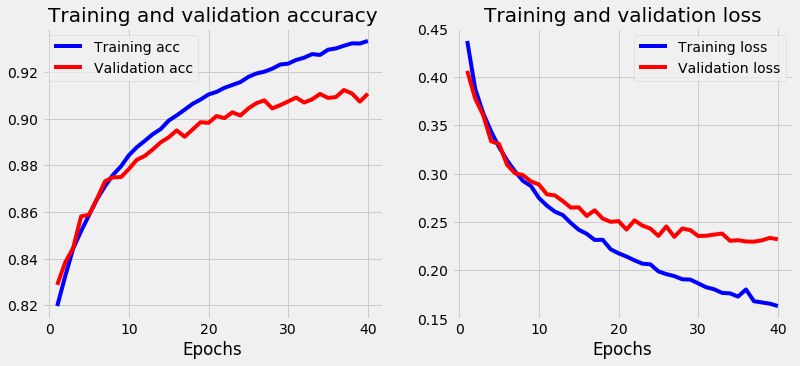

In [26]:
plot_history(history, 'loanword_detectory_val_acc.256x256nn.png')

## Tips for parameter tuning
* Set a seed for random on the Python and library levels, as done early in this notebook
* Be sure to recreate and compile your model fresh with each training session;
    * If you rerun the .fit() method, you’ll start off with the computed weights from the previous training.
* Study the history plots of each run, notice where training and validation characteristically starts to diverge more and more.
    * Your training and validation graphs may have local minima, so you might not be able to use early stopping automatically.
* Keep your validation and test (unseen) scores close; if they diverge, you're overfitting on the training and validation data.

## Fit final model

In [27]:
all_X_scaled = scaler.fit_transform(all_X.astype(np.float32))

model = Sequential(name='Loanword detector')
model.add(Dense(256, name='Dense_layer_1',
                input_dim=num_features, activation='relu'))
model.add(Dense(256, name='Dense_layer_2',
                activation='relu'))
model.add(Dense(1, name='Dense_layer_3', activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer= 'adam',
              metrics=['accuracy'])  
model.fit(all_X_scaled, all_y,
                     epochs=26,
                     verbose=False,                     
                     batch_size=32)
model.save('loanword_detector.greek_latin.keras.h5')

## Load the model and call it a run time (don't use pickle)

In [28]:
mymodel = load_model('loanword_detector.greek_latin.keras.h5')

In [35]:
the_char_idx = {' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'X': 22, 'Y': 23, 'Z': 24, 'a': 25, 'b': 26, 'c': 27, 'd': 28, 'e': 29, 'f': 30, 'g': 31, 'h': 32, 'i': 33, 'k': 34, 'l': 35, 'm': 36, 'n': 37, 'o': 38, 'p': 39, 'q': 40, 'r': 41, 's': 42, 't': 43, 'u': 44, 'v': 45, 'x': 46, 'y': 47, 'z': 48, 'Å': 49, 'Ē': 50, 'ē': 51, 'Ō': 52, 'ō': 53}

def encode_word(word, char_idx, max_len=28):
    vals =np.zeros(max_len)
    for idx, car in enumerate(word):
        vals[idx] = char_idx.get(car, 0) / len(char_idx) # total_uniq_char_count
    return vals

In [42]:
def is_greek(word):
    x = [encode_word(word, the_char_idx, max_len=28)]
    # Use the fitted transformer, load from a pickle if necessary
    x=np.array(x).astype(np.float32)
    x = scaler.transform(x) 
    return mymodel.predict(x)

In [43]:
is_greek('arxomai') 

array([[0.1272271]], dtype=float32)

In [44]:
is_greek('veritas')

array([[0.15047942]], dtype=float32)

In [45]:
is_greek('thuon')

array([[0.9263797]], dtype=float32)

In [48]:
! ls -lh  loanword_detector.greek_latin.keras.h5

-rw-r--r-- 1 todd todd 889K Mar 29 14:13 loanword_detector.greek_latin.keras.h5


## Comparing the scikit learn classifier vs. the Keras Neural Net
* RandomForest Classifier
    * 626 MB pickle size
    * accuracy: 96%
* Keras Neural Net
    * 889 kb h5 pickle size
    * accuracy: 92.88%

These results are typical for a relatively small dataset. Decision tree classifiers do very well, but can be prone to overfitting; and on the downside, the decision tree model is somewhat large. The neural net is small and is not overfitting. It is more compact and quite performant, and should a worthwhile consideration.

Both models might benefit from training with more data, and this is an area for future investigation.

## When to use which model?
* trying to win a Kaggle competition, choose the highest scoring one, even if it overfits ;-)
* need to deploy at scale? Consider sacrificing a few percentage points for a smaller model size for:
    * smaller memory footprint
    * more throughput

# That's all for now folks!